=============Splitting the data=============
Data shape: (5572, 2)
X_Train shape: (3900,), y_train shape: (3900,)
X_Test shape: (1672,), y_test shape: (1672,)
==============Convert Sentences to Sequences================
Found 7501 unique tokens.
Training Data shape: (3900, 189)
Testing Data shape: (1672, 189)
===============Create The Model==========================
Training model...........
Epoch 1/20
3900/3900 [==============================] - 139s 36ms/step - loss: 0.2879 - accuracy: 0.8795 - val_loss: 0.1887 - val_accuracy: 0.9426
Epoch 2/20
3900/3900 [==============================] - 132s 34ms/step - loss: 0.1165 - accuracy: 0.9690 - val_loss: 0.0957 - val_accuracy: 0.9725
Epoch 3/20
3900/3900 [==============================] - 133s 34ms/step - loss: 0.0517 - accuracy: 0.9856 - val_loss: 0.0645 - val_accuracy: 0.9803
Epoch 4/20
3900/3900 [==============================] - 134s 34ms/step - loss: 0.0281 - accuracy: 0.9910 - val_loss: 0.0612 - val_accuracy: 0.9833
Epoch 5/20
3900/3

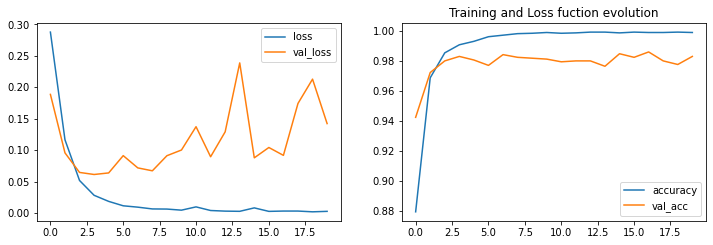

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def plot_loss_evaluation(r):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_acc')
    plt.legend()
    
    plt.title('Training and Loss fuction evolution')
    
def evaluate(model, X_train, X_test, y_train, y_test):
    y_pred_train = np.round(model.predict(data_train))
    y_pred_test = np.round(model.predict(data_test))
    
    print("=============Training Data===============")
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))
    print(f"Accuracy score: {accuracy_score(y_train, y_pred_train) * 100:.2f}%")
    
    print("=============Testing Data===============")
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    print(f"Accuracy score: {accuracy_score(y_test, y_pred_test) * 100:.2f}%")
    
data = pd.read_csv("data/sms.tsv", delimiter='\t', names=['label', 'message'])
data['label'] = data['label'].map({'ham':0, 'spam':1})

print('=============Splitting the data=============')
X = data.message
y = data.label
print(f'Data shape: {data.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'X_Train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_Test shape: {X_test.shape}, y_test shape: {y_test.shape}')

print('==============Convert Sentences to Sequences================')
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# pad sequence do that we get a NxT matrix
data_train = pad_sequences(sequences_train)
data_test = pad_sequences(sequences_test, maxlen=data_train.shape[1])
print(f"Found {len(tokenizer.word_index)} unique tokens.")
print(f"Training Data shape: {data_train.shape}")
print(f"Testing Data shape: {data_test.shape}")

print('===============Create The Model==========================')
# We get to choose embedding dimensionality
D = 30
# Hidden state dimentionality
M = 30
V = len(tokenizer.word_index)
T = data_train.shape[1]

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

# Compile and fit
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print('Training model...........')
r = model.fit(data_train, y_train, epochs=20, 
              validation_data=(data_test, y_test), 
              batch_size=1)

print('================Model Evaluation=====================')
evaluate(model, data_train, data_test, y_train, y_test)
plot_loss_evaluation(r)